In [1]:
# import default libraries
import os
import json
import pathlib
import zipfile
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

# matplotlib darkmode
plt.style.use('dark_background')

# styling
plt.rcParams.update({
    "font.size": 14
})


In [2]:
with open ('../data.json') as f:
    credentials = json.load(f)

access_key = credentials["AWS_ACCESS_KEY_ID"]
secret_key = credentials["AWS_SECRET_ACCESS_KEY"]

In [3]:
import pickle
from pyspark.sql import SparkSession

# Initialize the Spark session
spark = (
    SparkSession.builder.appName("S3ReadExample")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.262")
    .config("spark.hadoop.fs.s3a.access.key", access_key)
    .config("spark.hadoop.fs.s3a.secret.key", secret_key)
    .config("spark.hadoop.fs.s3a.endpoint", "s3.eu-north-1.amazonaws.com")
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .getOrCreate()
)

# Load the pickle file as binary using Spark
# binary_rdd = spark.sparkContext.binaryFiles("s3a://astavak/test.pkl")

binary_rdd = spark.sparkContext.binaryFiles("s3a://astavak/home/astavak/cassini/data/level1/CDA__CAT_IID_cal_data.pkl")

# Extract and unpickle the data
def unpickle_file(content):
    return pickle.loads(content)

# Map over the RDD and load the pickle content
unpickled_data = binary_rdd.map(lambda kv: unpickle_file(kv[1]))

# Collect and print the unpickled data
data = unpickled_data.collect()
print(data)

spark.stop()

24/12/18 06:43:46 WARN Utils: Your hostname, archlinux resolves to a loopback address: 127.0.0.1; using 192.168.1.82 instead (on interface wlp2s0)
24/12/18 06:43:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/astavak/.pyenv/versions/3.11.0/envs/venv3.11/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/astavak/.ivy2/cache
The jars for the packages stored in: /home/astavak/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5620e58d-5248-4dd5-be1e-c50c05db9fa8;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 202ms :: artifacts dl 7ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|ev

[      PSU_VEL  PSU_CHARGE  MP_PEAKS      ACC   QI_CHARGE  QI_TR  QC_CHARGE  \
0       17.40       1.260         3  2000000    8.857710   2.83    43.1122   
1       12.35       0.990         0  2000000    8.392480   8.16   243.3150   
2       18.70       2.030         3  2000000    3.897020   4.00    47.3741   
3       29.10       2.058         6  2000000  102.422000   4.33   496.7530   
4       11.00       2.030         0  2000000    0.781009   1.33    42.1289   
...       ...         ...       ...      ...         ...    ...        ...   
4204     9.68       2.429         7  2000000   10.227700   2.84   166.8690   
4205    14.78       0.990         9  2000000   25.061000   2.83   219.0310   
4206    14.89       0.990         4  2000000    7.616550   3.33    42.1660   
4207    12.29       2.506         6  2000000   30.925100   5.34   261.7860   
4208    12.65       1.806         7  2000000    7.527550   4.84    79.2491   

      QC_TR  QT_CHARGE  QT_TR  TAR          MASS  
0      2.33

In [4]:
cal_df = data[0]

In [5]:
# unweighted calibration ml model for IID
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

# Adding the LOG10 scaled data of the QI channel
iid_qi_cal_df.loc[:, "QI_LOG10_CHARGE"] = np.log10(iid_qi_cal_df["QI_CHARGE"])

# Considering only "relevant" data: rise time, log10 charge and the velocity
# iid_qi_cal_df = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL"]]

In [4]:
iid_qi_cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS,QI_LOG10_CHARGE
829,4.09,31.3600,0,2000000,43.9482,57.00,206.00900,14.83,176.9120,46.67,IID,7.498760e-15,1.642941
830,4.07,31.9200,0,2000000,42.6352,54.00,166.73900,16.33,204.9460,43.67,IID,7.707864e-15,1.629768
831,4.10,30.6600,0,2000000,48.6620,59.16,187.83500,21.34,189.8550,44.34,IID,7.295657e-15,1.687190
832,4.11,33.3200,0,2000000,51.0875,59.50,174.90200,18.50,211.9450,44.00,IID,7.890079e-15,1.708315
833,4.07,74.9000,0,2000000,130.3050,55.67,415.97200,12.83,428.5020,39.33,IID,1.808644e-14,2.114961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,7.93,4.5087,0,2000000,12.9795,32.17,7.54071,18.67,48.9116,32.33,IID,2.867906e-16,1.113258
3742,8.23,4.9609,0,2000000,16.3490,28.84,37.73430,18.66,52.7411,25.67,IID,2.929684e-16,1.213491
3743,8.21,3.9368,0,2000000,13.3384,37.50,18.02220,18.67,42.9590,40.67,IID,2.336238e-16,1.125104
3744,7.84,4.2826,0,2000000,14.6953,19.33,14.16240,32.33,55.5990,19.67,IID,2.786990e-16,1.167178


In [5]:
iid_qi_cal_df.describe()

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,MASS,QI_LOG10_CHARGE
count,1634.000000,1634.000000,1634.0,1.634000e+03,1634.000000,1634.000000,1.634000e+03,1634.000000,1.634000e+03,1634.000000,1.634000e+03,1634.000000
mean,10.036346,20.161700,0.0,1.983048e+06,53.210788,40.512815,3.392901e+15,16.556408,3.695838e+15,39.712827,6.519395e-15,1.416504
std,9.302421,29.037159,0.0,9.312044e+04,71.322299,16.762827,1.801622e+16,10.291624,1.877350e+16,21.288395,1.764761e-14,0.524261
min,1.590000,0.840000,0.0,1.350000e+06,0.461755,0.340000,-1.867510e-01,0.000000,-8.681840e+00,0.000000,1.118135e-18,-0.335588
25%,4.230000,3.657675,0.0,2.000000e+06,11.650400,26.500000,2.988340e+01,10.000000,4.005070e+01,24.000000,1.713061e-16,1.066341
50%,7.030000,9.380000,0.0,2.000000e+06,23.205300,44.000000,7.199450e+01,17.335000,9.884825e+01,43.660000,7.687655e-16,1.365587
75%,11.075000,23.370375,0.0,2.000000e+06,63.704750,53.170000,1.634565e+02,23.660000,3.050810e+02,56.000000,3.881211e-15,1.804166
max,69.700000,385.000000,0.0,2.000000e+06,710.416000,89.830000,9.900000e+16,58.840000,9.900000e+16,99.670000,2.976114e-13,2.851513


Text(0.5, 0, 'PSU velocity in km/s')

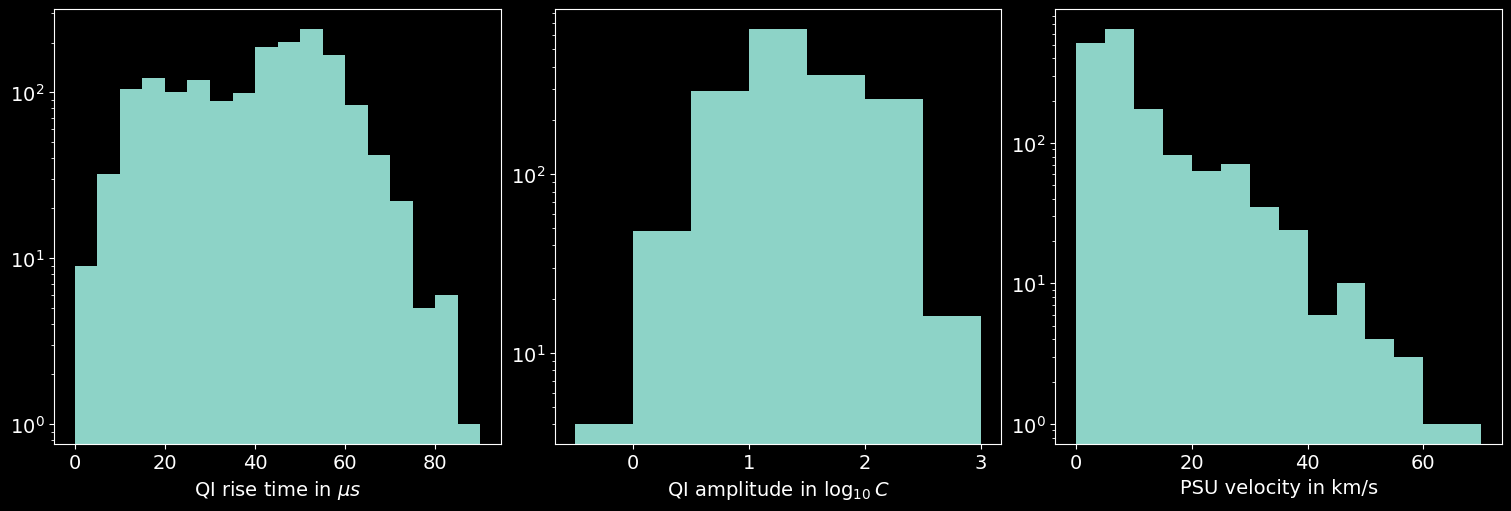

In [6]:
# histograms of distributions before spliting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    layout="constrained",
                                    sharey=False,
                                    figsize=(15,5))

# add the QI rise time
ax1.hist(iid_qi_cal_df["QI_TR"], bins=np.arange(0,95,5))
ax1.set_xlabel("QI rise time in " + r"$\mu s$")
ax1.set_yscale("log")

# QI amplitude
ax2.hist(iid_qi_cal_df["QI_LOG10_CHARGE"], bins=np.arange(-0.5,3.5,0.5))
ax2.set_yscale("log")
ax2.set_xlabel("QI amplitude in " + r"$\log_{10} C$")

# psu velocity
ax3.hist(iid_qi_cal_df["PSU_VEL"], bins=np.arange(0, 75, 5))
ax3.set_yscale("log")
ax3.set_xlabel("PSU velocity in km/s")

In [7]:
iid_qi_vel = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL"]].values

iid_qi_vel[0]

array([57.        ,  1.64294109,  4.09      ])

In [40]:
# to balance the weighing we can use bayesian blocks

# Creating Bayesian Blocks for the rise time
import astropy.stats
bblocks_vals, bblocks_edges = astropy.stats.histogram(a=iid_qi_cal_df["QI_TR"],
                                                      bins="blocks")

In [43]:
bblocks_vals

array([  4,  41, 632, 738,  86,  89,  31,  13])

In [41]:
bblocks_edges

array([ 0.34 ,  3.335, 10.415, 40.165, 57.335, 60.75 , 67.75 , 74.08 ,
       89.83 ])

Text(74.96673394097222, 0.5, 'Number of datapoints')

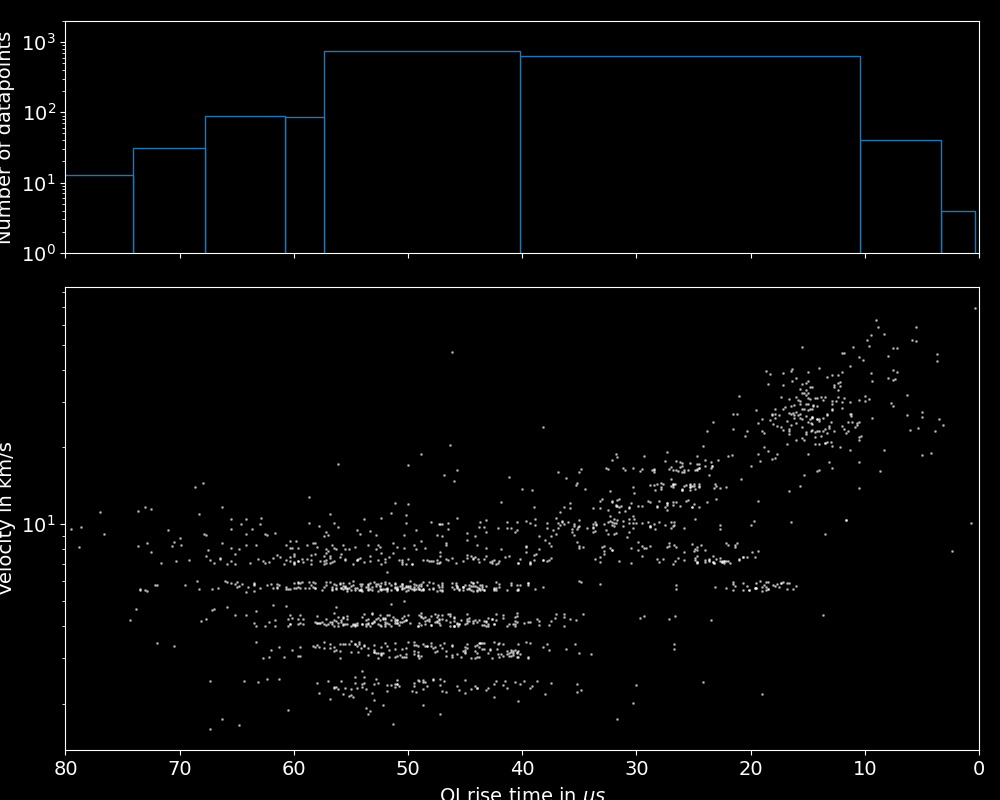

In [44]:
# Visualize the blocks above the shown scatter plot
import astropy.visualization

fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               figsize=(10, 8),
                               sharex=True,
                               height_ratios=[1, 2])

# Below: the calibration data as data points ...
ax2.scatter(iid_qi_cal_df["QI_TR"],
            iid_qi_cal_df["PSU_VEL"],
            s=1,
            alpha=0.5,
            color="w")

# Above: the Bayesian Blocks
_, _, _ = astropy.visualization.hist(x=iid_qi_cal_df["QI_TR"],
                                     bins="blocks",
                                     ax=ax1,
                                     facecolor="k",
                                     edgecolor="tab:blue")
ax1.set_yscale("log")
ax1.set_ylim(1, 2000)

plt.tight_layout()

plt.xlim(80, 0)

ax2.set_xlabel("QI rise time in $\mu s$")
ax2.set_ylabel("Velocity in km/s")
ax2.set_yscale("log")
ax1.set_ylabel("Number of datapoints")

In [8]:

# Additionally, shuffle the data to be REALLY sure that there is no "order bias"
np.random.shuffle(iid_qi_vel)

In [9]:
iid_qi_vel[0]

array([60.        ,  0.90778744,  7.55      ])

In [10]:
# split the data in training and testing data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(iid_qi_vel[:,:2],
                                                                            iid_qi_vel[:,-1],
                                                                            test_size=0.2)



In [11]:
X_train

array([[30.66      ,  0.83838875],
       [48.34      ,  2.05137637],
       [62.67      ,  1.66541306],
       ...,
       [46.17      ,  2.07737517],
       [24.84      ,  1.29326972],
       [55.5       ,  0.65275868]])

In [12]:
psu_vel_bins = np.arange(0,95,5)
qi_tr_bins = np.arange(0,100,10)
qi_ampl_bins = np.arange(-0.5,3.5,0.5)

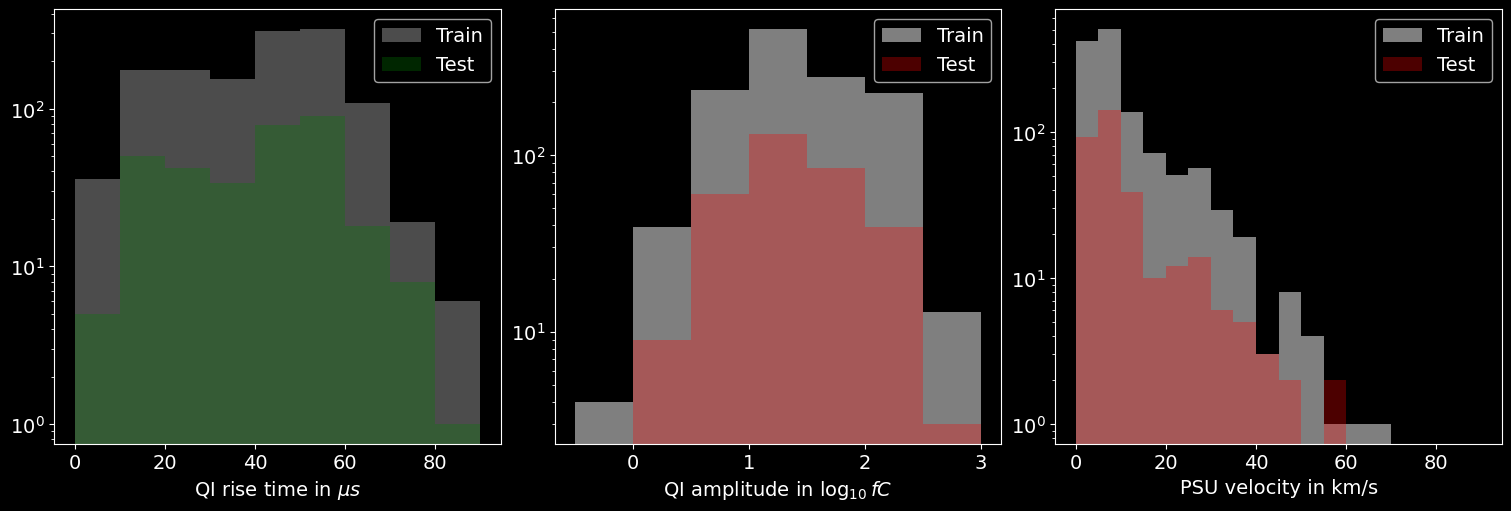

In [13]:
# after spliting unweighted distribution histogram plots

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    layout="constrained",
                                    sharey=False,
                                    figsize=(15,5))

ax1.hist(X_train[:, 0], bins=qi_tr_bins, alpha=0.3, color="white", label="Train")
ax1.hist(X_test[:, 0], bins=qi_tr_bins, alpha=0.3, color="green", label="Test")
ax1.set_yscale("log")
ax1.set_xlabel("QI rise time in " + r"$\mu s$")

ax1.legend(loc="upper right")

# Add the QI Amplitude
ax2.hist(X_train[:, 1], bins=qi_ampl_bins, alpha=0.5, color="white", label="Train")
ax2.hist(X_test[:, 1], bins=qi_ampl_bins, alpha=0.3, color="red", label="Test")
ax2.set_yscale("log")
ax2.set_xlabel("QI amplitude in " + r"$\log_{10} fC$")

ax2.legend(loc="upper right")

# Add the PSU velocity
ax3.hist(y_train, bins=psu_vel_bins, alpha=0.5, color="white", label="Train")
ax3.hist(y_test, bins=psu_vel_bins, alpha=0.3, color="red", label="Test")
ax3.set_yscale("log")
ax3.set_xlabel("PSU velocity in km/s")

ax3.legend(loc="upper right")

In [14]:
# shaping for the neural network datasets
print(f"Before reshaping: {y_train.shape}")

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"After reshaping: {y_train.shape}")

Before reshaping: (1307,)
After reshaping: (1307, 1)


In [15]:
# standardization
X_scaler = sklearn.preprocessing.StandardScaler()
y_scaler = sklearn.preprocessing.StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [16]:
# resulting mean and std of the data
print(f"Mean of the training features: {X_train_scaled.mean(axis=0)}")
print(f"Standard Deviation of the training features: {X_train_scaled.std(axis=0)}")

Mean of the training features: [-3.14718922e-15 -4.18503963e-15]
Standard Deviation of the training features: [1. 1.]


MACHINE LEARNING Training with simple neural network

W0000 00:00:1734165586.577281    9883 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


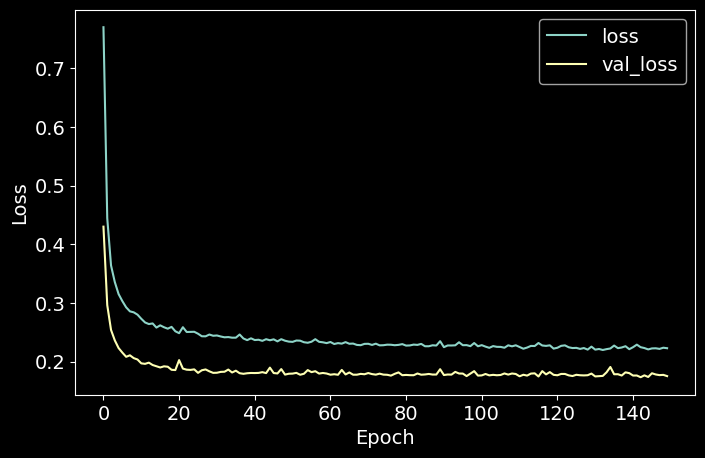

In [17]:
# neural network wirh 2 hidden layers in this first regression

# input shape is 2: rise time and charge
inputs = tf.keras.Input(shape=(2,),
                        name="iid_qi_data",)

# 2 hidden layers
layer = tf.keras.layers.Dense(units=64, activation="relu",)(inputs)
layer = tf.keras.layers.Dense(units=32, activation="relu",)(layer)

# output layer with only 1 unit mapping to get the results of velocity vallues
output = tf.keras.layers.Dense(units=1, name="psu_vel",)(layer)

# we use model API rather than sequential
model = tf.keras.Model(inputs=inputs, outputs=output)

# lots of different losses and metrics
model.compile(optimizer="adam",
            loss=["mean_squared_error"],
            metrics=[tf.keras.metrics.RootMeanSquaredError(),
                    "mean_absolute_error"])

model.fit(x=X_train_scaled,
        y=y_train_scaled,
        batch_size=32,
        epochs=150,
        validation_split=0.25,
        verbose=0)

plt.figure(figsize=(8,5))
plt.plot(model.history.history["loss"], label="loss")
plt.plot(model.history.history["val_loss"], label="val_loss")
plt.xlabel(f"Epoch")
plt.ylabel(f"Loss")
plt.legend()

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ iid_qi_data (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ psu_vel (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,917 (27.02 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,612 (18.02 KB)

In [19]:
# evaluating model in the standardized scale
_, mae_scaled, rmse_scaled = model.evaluate(X_test_scaled, y_test_scaled)

rmse = y_scaler.inverse_transform([[rmse_scaled]])
mae = y_scaler.inverse_transform([[mae_scaled]])

print(f"RMSE on test data in km/s : {rmse[0][0]}")
print(f"MAE on test data in km/s: {mae[0][0]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3978 - mean_absolute_error: 0.3398 - root_mean_squared_error: 0.6206
RMSE on test data in km/s : 12.991467708633099
MAE on test data in km/s: 14.993431594333256


In [20]:
# rescaling the data to fit the 3d mesh for a hyperplane passing through
# the values in 3d scatter earlier
min_rt, min_log10ampl = X_scaler.transform([[1, 0.5]])[0]
max_rt, max_log10ampl = X_scaler.transform([[60, 2.6]])[0]


# generate linspaced values in between to fit the grid
rise_time_range_scaled = np.linspace(min_rt,
                                    max_rt,
                                    100)

log_fc_range_scaled = np.linspace(min_log10ampl,
                                max_log10ampl,
                                100)

rise_time_range_scaled, log_fc_range_scaled = np.meshgrid(rise_time_range_scaled,
                                                        log_fc_range_scaled)



In [21]:
rise_time_range_scaled

array([[-2.34909535, -2.3135592 , -2.27802306, ...,  1.09791082,
         1.13344697,  1.16898311],
       [-2.34909535, -2.3135592 , -2.27802306, ...,  1.09791082,
         1.13344697,  1.16898311],
       [-2.34909535, -2.3135592 , -2.27802306, ...,  1.09791082,
         1.13344697,  1.16898311],
       ...,
       [-2.34909535, -2.3135592 , -2.27802306, ...,  1.09791082,
         1.13344697,  1.16898311],
       [-2.34909535, -2.3135592 , -2.27802306, ...,  1.09791082,
         1.13344697,  1.16898311],
       [-2.34909535, -2.3135592 , -2.27802306, ...,  1.09791082,
         1.13344697,  1.16898311]])

In [22]:
log_fc_range_scaled

array([[-1.74202023, -1.74202023, -1.74202023, ..., -1.74202023,
        -1.74202023, -1.74202023],
       [-1.70192708, -1.70192708, -1.70192708, ..., -1.70192708,
        -1.70192708, -1.70192708],
       [-1.66183394, -1.66183394, -1.66183394, ..., -1.66183394,
        -1.66183394, -1.66183394],
       ...,
       [ 2.14701466,  2.14701466,  2.14701466, ...,  2.14701466,
         2.14701466,  2.14701466],
       [ 2.1871078 ,  2.1871078 ,  2.1871078 , ...,  2.1871078 ,
         2.1871078 ,  2.1871078 ],
       [ 2.22720095,  2.22720095,  2.22720095, ...,  2.22720095,
         2.22720095,  2.22720095]])

In [23]:
np.hstack([rise_time_range_scaled, log_fc_range_scaled])

array([[-2.34909535, -2.3135592 , -2.27802306, ..., -1.74202023,
        -1.74202023, -1.74202023],
       [-2.34909535, -2.3135592 , -2.27802306, ..., -1.70192708,
        -1.70192708, -1.70192708],
       [-2.34909535, -2.3135592 , -2.27802306, ..., -1.66183394,
        -1.66183394, -1.66183394],
       ...,
       [-2.34909535, -2.3135592 , -2.27802306, ...,  2.14701466,
         2.14701466,  2.14701466],
       [-2.34909535, -2.3135592 , -2.27802306, ...,  2.1871078 ,
         2.1871078 ,  2.1871078 ],
       [-2.34909535, -2.3135592 , -2.27802306, ...,  2.22720095,
         2.22720095,  2.22720095]])

In [24]:
# plotting the z-axis with the help of meshgrid
rise_time_range = []
log_fc_range = []
pred_vel = []

for _rt, _fc in zip(rise_time_range_scaled, log_fc_range_scaled):
     stacked_scaled = np.hstack([_rt.reshape(-1,1),
                                _fc.reshape(-1,1)])

     # rise time and log_fc scalings
     rise_time_range.append(X_scaler.inverse_transform(stacked_scaled)[:, 0])
     log_fc_range.append(X_scaler.inverse_transform(stacked_scaled)[:,1])

     # pred. vel. stacked scaling
     temp_results = model.predict(x=stacked_scaled)
     pred_vel.append(y_scaler.inverse_transform(temp_results.reshape(1,-1))[0])

pred_vel = np.array(pred_vel)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 750

In [25]:
stacked_scaled[0]

array([-2.34909535,  2.22720095])

In [32]:
rise_time_range

[array([ 1.        ,  1.5959596 ,  2.19191919,  2.78787879,  3.38383838,
         3.97979798,  4.57575758,  5.17171717,  5.76767677,  6.36363636,
         6.95959596,  7.55555556,  8.15151515,  8.74747475,  9.34343434,
         9.93939394, 10.53535354, 11.13131313, 11.72727273, 12.32323232,
        12.91919192, 13.51515152, 14.11111111, 14.70707071, 15.3030303 ,
        15.8989899 , 16.49494949, 17.09090909, 17.68686869, 18.28282828,
        18.87878788, 19.47474747, 20.07070707, 20.66666667, 21.26262626,
        21.85858586, 22.45454545, 23.05050505, 23.64646465, 24.24242424,
        24.83838384, 25.43434343, 26.03030303, 26.62626263, 27.22222222,
        27.81818182, 28.41414141, 29.01010101, 29.60606061, 30.2020202 ,
        30.7979798 , 31.39393939, 31.98989899, 32.58585859, 33.18181818,
        33.77777778, 34.37373737, 34.96969697, 35.56565657, 36.16161616,
        36.75757576, 37.35353535, 37.94949495, 38.54545455, 39.14141414,
        39.73737374, 40.33333333, 40.92929293, 41.5

In [36]:
log_fc_range

[array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 array([0.52121212, 0.52121212, 0.52121212, 0.52121212, 0.52121212,
        0.52121212, 0.52121212, 0.52121212, 0.52121212, 0.52121212,
        0.52121212, 0.52121212, 0.52121212, 0.52121212, 0.52121212,
        0.52121212, 0.52121212, 0.52121212, 0.52121212, 0.52121212,
        0.52121212, 0.52121212, 0.52121212, 0.52121212, 0.52121212,
        0.52121212, 0.52121212, 0.52121212, 0.52121212, 0.52121212,
        0.52121212, 0.5212

In [38]:
pred_vel.shape

(100, 100)

In [26]:
iid_qi_cal_df

,PSU_VEL,PSU_CHARGE,MP_PEAKS,ACC,QI_CHARGE,QI_TR,QC_CHARGE,QC_TR,QT_CHARGE,QT_TR,TAR,MASS,QI_LOG10_CHARGE
829,4.09,31.3600,0,2000000,43.9482,57.00,206.00900,14.83,176.9120,46.67,IID,7.498760e-15,1.642941
830,4.07,31.9200,0,2000000,42.6352,54.00,166.73900,16.33,204.9460,43.67,IID,7.707864e-15,1.629768
831,4.10,30.6600,0,2000000,48.6620,59.16,187.83500,21.34,189.8550,44.34,IID,7.295657e-15,1.687190
832,4.11,33.3200,0,2000000,51.0875,59.50,174.90200,18.50,211.9450,44.00,IID,7.890079e-15,1.708315
833,4.07,74.9000,0,2000000,130.3050,55.67,415.97200,12.83,428.5020,39.33,IID,1.808644e-14,2.114961
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,7.93,4.5087,0,2000000,12.9795,32.17,7.54071,18.67,48.9116,32.33,IID,2.867906e-16,1.113258
3742,8.23,4.9609,0,2000000,16.3490,28.84,37.73430,18.66,52.7411,25.67,IID,2.929684e-16,1.213491
3743,8.21,3.9368,0,2000000,13.3384,37.50,18.02220,18.67,42.9590,40.67,IID,2.336238e-16,1.125104
3744,7.84,4.2826,0,2000000,14.6953,19.33,14.16240,32.33,55.5990,19.67,IID,2.786990e-16,1.167178


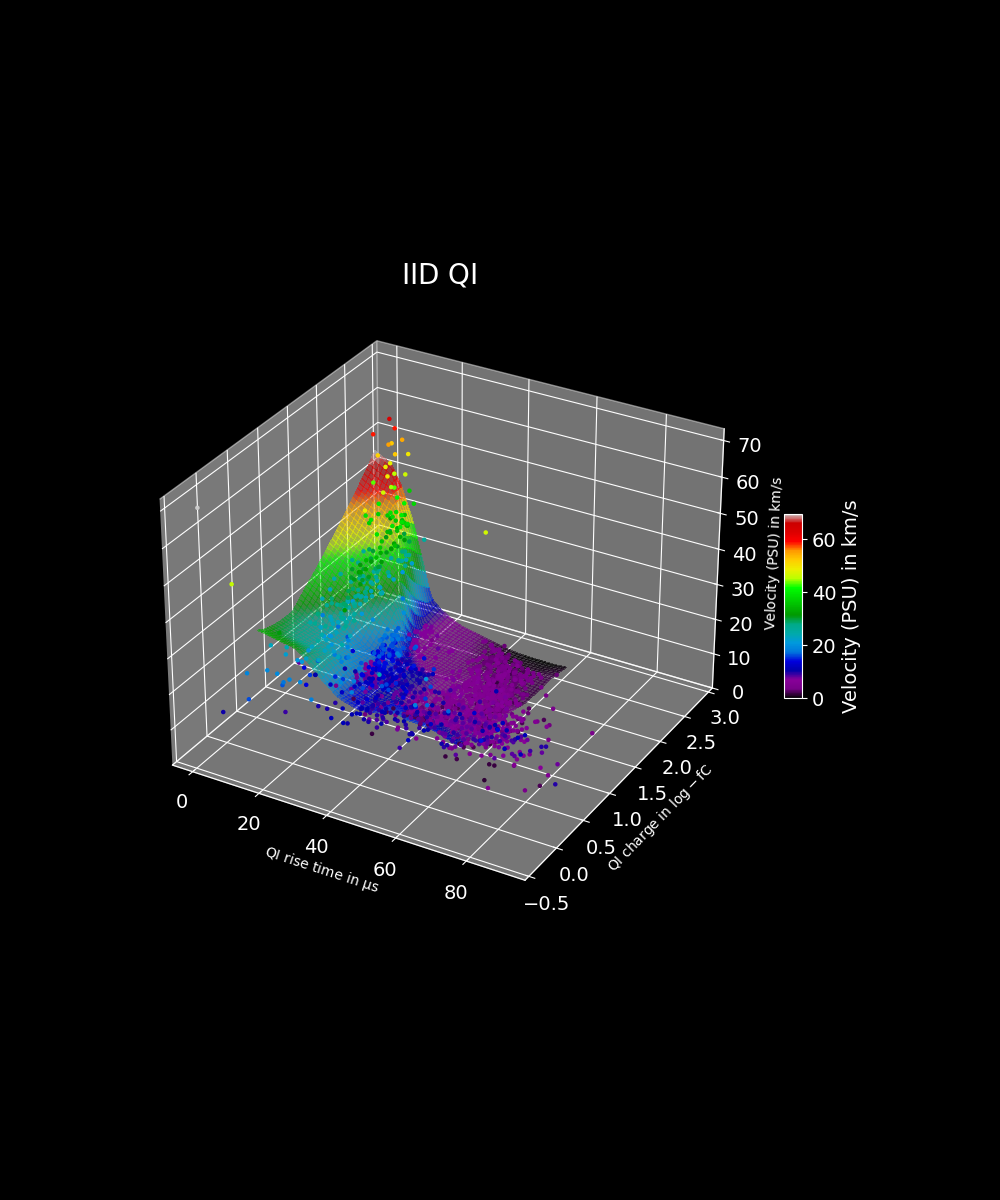

In [46]:
%matplotlib widget

# channel
ch = "QI"

# 3D plot
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection="3d")

# scatter plot with log10 charges
sc = ax.scatter(iid_qi_cal_df[ch + '_TR'],
                np.log10(iid_qi_cal_df[ch + '_CHARGE']),
                iid_qi_cal_df['PSU_VEL'],
                c=iid_qi_cal_df['PSU_VEL'],
                cmap="nipy_spectral",
                vmin=0,
                vmax=np.max(iid_qi_cal_df["PSU_VEL"]),
                marker=".",
                alpha=1,
                zorder=0)

ax.set_title(rf"$\mathrm{{IID\ {ch}}}$", fontsize=20)

ax.set_xlabel(rf"$\mathrm{{{ch}\ rise\ time\ in\ \mu s}}$", fontsize=10)
ax.set_ylabel(rf"$\mathrm{{{ch}\ charge\ in\ log-fC}}$", fontsize=10)
ax.set_zlabel(rf"$\mathrm{{Velocity\ (PSU)\ in\ km/s}}$", fontsize=10)

ax.set_zlim(0, 1.05 * np.max(iid_qi_cal_df["PSU_VEL"]))
ax.tick_params(labelsize=14)

# add a regression line
ax.plot_surface(rise_time_range,
                log_fc_range,
                pred_vel,
                cmap="nipy_spectral",
                linewidth=0,
                antialiased=False,
                alpha=0.5)

# create a colorbar
cbar = fig.colorbar(sc,
                    shrink=0.2,
                    aspect=10,
                    orientation="vertical",
                    pad=0.04)

cbar.ax.tick_params(labelsize=14)
cbar.set_label(label=r"Velocity (PSU) in km/s",
                size=14)

plt.show()
